# Analysis of Los Angeles Restaurants

Fernando Soares Goudard

You have decided to open a small coffee shop with robot waiters in Los Angeles. It is a very promising but expensive project, so you and your partners decide to try to attract investors. They are interested in current market conditions and want to know if you will be able to maintain your success once the novelty of robot waiters wears off.

You are an analysis guru, so your partners have asked you to prepare market research. You have open-source data on restaurants in LA.

In [1]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Part 1.
##### Load and prepare the data

In [2]:
df = pd.read_csv('rest_data_us_upd.csv')
df.info()
print()
print(df.sample(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9651 entries, 0 to 9650
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           9651 non-null   int64 
 1   object_name  9651 non-null   object
 2   address      9651 non-null   object
 3   chain        9648 non-null   object
 4   object_type  9651 non-null   object
 5   number       9651 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 452.5+ KB

         id           object_name                   address  chain  \
733   12519          NATALEE THAI      998 S ROBERTSON BLVD   True   
5167  16953     COFFEE CONNECTION      3838 S CENTINELA AVE  False   
501   12287            FARSI CAFE        1916 WESTWOOD BLVD  False   
6621  18407   BIG SUGAR BAKE SHOP           612 S FLOWER ST  False   
2798  14584     VONS MARKET #2270      4030 S CENTINELA AVE  False   
6589  18375         LA TECLENA #2            1443 W 11TH ST  False   
4641  16427          SU

In [3]:
print('Numero de duplicatas:', df.duplicated().sum())
print('Numero de duplicatas (id):', df['id'].duplicated().sum())

Numero de duplicatas: 0
Numero de duplicatas (id): 0


We can see that we don't have any duplicate IDs or rows. Let's look at the null values we have in the chain column.

In [4]:
print(df[df['chain'].isna()])

         id              object_name               address chain object_type  \
7408  19194  TAQUERIA LOS 3 CARNALES  5000 E WHITTIER BLVD   NaN  Restaurant   
7523  19309     JAMMIN JIMMY'S PIZZA   1641 FIRESTONE BLVD   NaN       Pizza   
8648  20434    THE LEXINGTON THEATER          129 E 3RD ST   NaN  Restaurant   

      number  
7408      14  
7523       1  
8648      35  


We have three establishments that do not have information in the chain column. It makes sense that the names of franchised stores appear repeatedly in the list, while non-franchised stores appear only once.

In [5]:
chain_duplicated = df[df['chain']==True]['object_name'].duplicated().sum()
n_chain_duplicated = df[df['chain']==False]['object_name'].duplicated().sum()

print(f'We have {chain_duplicated} duplicated chain names, and {n_chain_duplicated} dupicated non chain (independent) names.')

We have 943 duplicated chain names, and 29 dupicated non chain (independent) names.


We can see that we have many more duplicate names for franchises than for non-franchises.

Let's check if there are other establishments with the three names on the list. If there are, we can consider them to be franchises; if not, we will not consider them to be franchises.

In [6]:
res_list = df[df['chain'].isna()]['object_name']
print(df[df['object_name'].isin(res_list)].duplicated().sum())


0


None of the three names have duplicates, so we will fill in the null values with False.

In [7]:
df.fillna({'chain':False}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9651 entries, 0 to 9650
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           9651 non-null   int64 
 1   object_name  9651 non-null   object
 2   address      9651 non-null   object
 3   chain        9651 non-null   bool  
 4   object_type  9651 non-null   object
 5   number       9651 non-null   int64 
dtypes: bool(1), int64(2), object(3)
memory usage: 386.5+ KB


C:\Users\Fernando\AppData\Local\Temp\ipykernel_11708\1483544056.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna({'chain':False}, inplace=True)


Finally, let's check if any other columns can be changed in order to optimize the space occupied by the dataframe and the execution time for the next steps:

id -> already set to int64, nothing to do
object_name -> needs to be string (object), nothing to do
address -> needs to be string (object), nothing to do
chain -> already set to bool, nothing to do
object_type -> set to string (object), but appears to be category type
number -> already set to int64, nothing to do

let's confirm if ‘object_type’ should be changed to category type and change it

In [8]:
print(df['object_type'].unique())
print(df['object_type'].nunique())

['Cafe' 'Restaurant' 'Fast Food' 'Bakery' 'Bar' 'Pizza']
6


We only have 6 unique values for the entire column, so let's transform it into a category type.

In [9]:
df['object_type'] = df['object_type'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9651 entries, 0 to 9650
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   id           9651 non-null   int64   
 1   object_name  9651 non-null   object  
 2   address      9651 non-null   object  
 3   chain        9651 non-null   bool    
 4   object_type  9651 non-null   category
 5   number       9651 non-null   int64   
dtypes: bool(1), category(1), int64(2), object(2)
memory usage: 320.8+ KB


Now we are ready to analyze the data:

### Part 2.
##### Data analysis.

Let's take a look at the proportion of restaurant types.

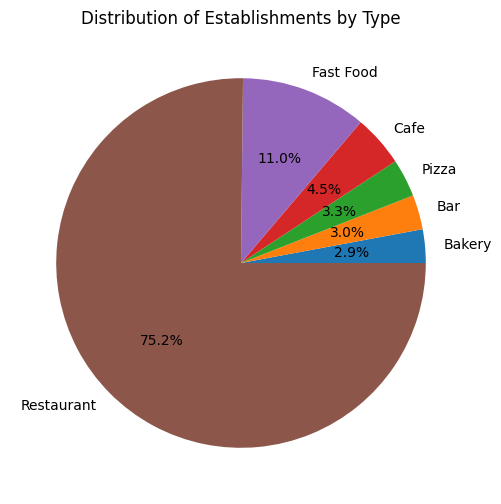

In [10]:
res_by_type = df.groupby('object_type', as_index=False, observed=False).agg({'id':'count'})
res_by_type.columns = ['type','count']
res_by_type.sort_values(by='count', ascending=True, inplace=True)

plt.figure(figsize=(6,6))
plt.pie(res_by_type['count'], labels=res_by_type['type'], autopct='%1.1f%%')
plt.title('Distribution of Establishments by Type')
plt.show()

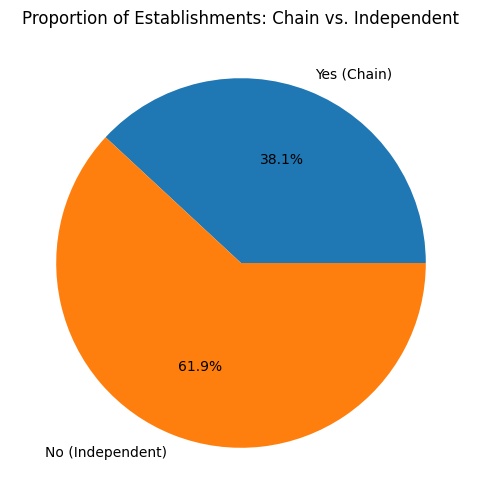

In [11]:
res_by_chain = df.groupby('chain', as_index=False, observed=False).agg({'id':'count'})
res_by_chain.columns = ['chain','count']
res_by_chain.sort_values(by='count', ascending=True, inplace=True)
labels = ['Yes (Chain)','No (Independent)']
plt.figure(figsize=(6,6))
plt.pie(res_by_chain['count'], labels=labels, autopct='%1.1f%%')
plt.title('Proportion of Establishments: Chain vs. Independent')
plt.show()

Let's take a look at the proportion of seats by type of establishment.

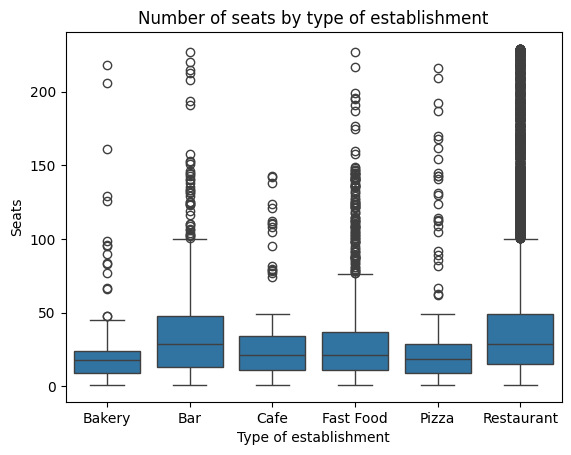

In [12]:
fig = sns.boxplot(data=df, x='object_type', y='number')
fig.set_title('Number of seats by type of establishment')
fig.set_ylabel('Seats')
fig.set_xlabel('Type of establishment')
plt.show()

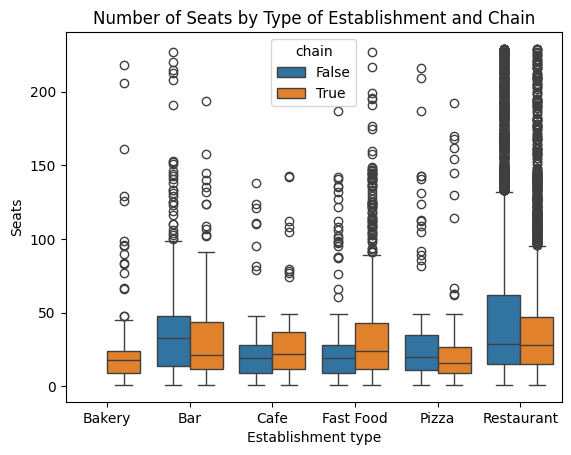

In [13]:
fig = sns.boxplot(data=df, x='object_type', y='number', hue='chain')
fig.set_title('Number of Seats by Type of Establishment and Chain')
fig.set_ylabel('Seats')
fig.set_xlabel('Establishment type')
plt.show() 

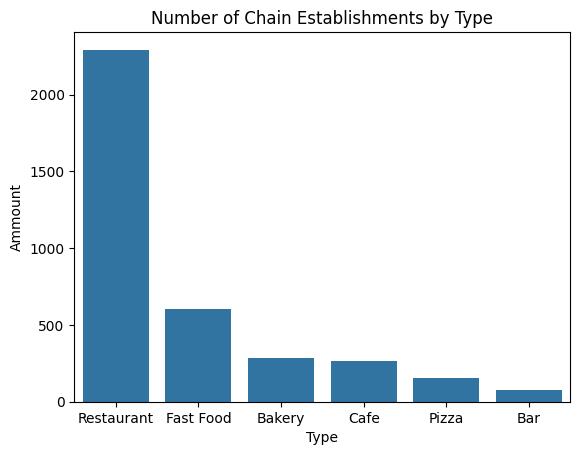

In [14]:
df_g = df[df['chain']==True].groupby('object_type', as_index=False, observed=False).agg({'object_name':'count'})
order = df_g.sort_values('object_name', ascending=False)['object_type']
fig = sns.barplot(data=df_g, x='object_type', y='object_name', order = order)
fig.set_title('Number of Chain Establishments by Type')
fig.set_ylabel('Ammount')
fig.set_xlabel('Type')
plt.show()

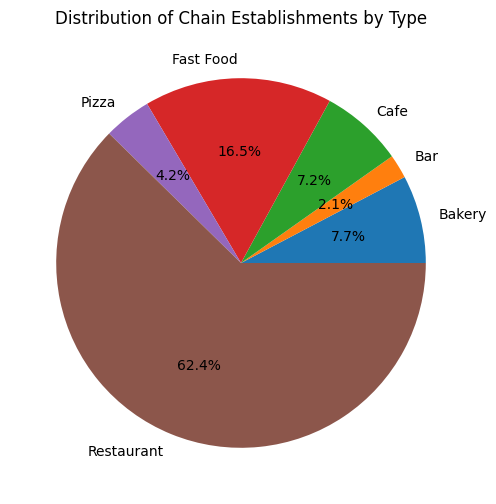

In [15]:
df_g.sort_values(by='object_type', inplace=True)
plt.figure(figsize=(6,6))
plt.pie(df_g['object_name'], labels=df_g['object_type'], autopct='%1.1f%%')
plt.title('Distribution of Chain Establishments by Type')
plt.show()

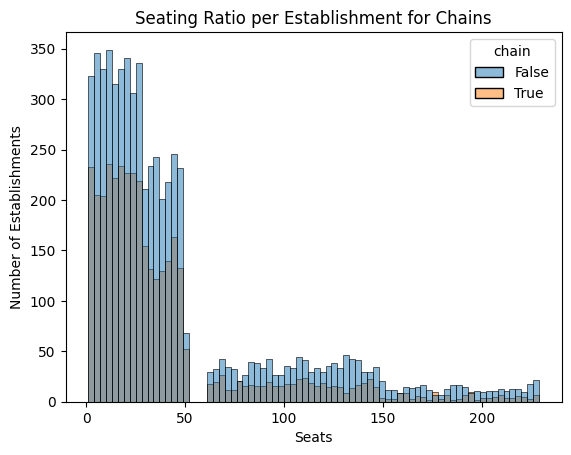

In [16]:
fig = sns.histplot(data=df, x='number', hue='chain')
fig.set_title('Seating Ratio per Establishment for Chains')
fig.set_xlabel('Seats')
fig.set_ylabel('Number of Establishments')
plt.show()

We can see that the networks are categorized by various establishments with few seats (up to 50).

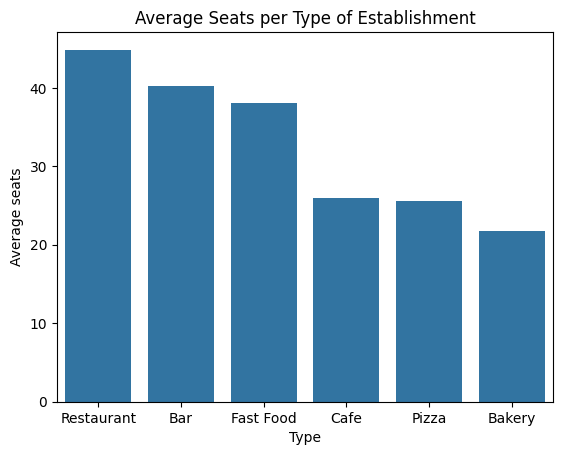

In [17]:
df_avg = df[df['chain']==True].groupby('object_type', as_index=False, observed=False).agg({'number':'mean'})
order = df_avg.sort_values('number', ascending=False)['object_type']
fig = sns.barplot(data=df_avg, x='object_type', y='number', order = order)
fig.set_title('Average Seats per Type of Establishment')
fig.set_ylabel('Average seats')
fig.set_xlabel('Type')
plt.show()

In [18]:
# function to extract only the street name from an address
# extracts: (number) (complement) (street) (suffix/number)
# example: (3708) (N) (EAGLE ROCK BLVD) (E23)
# returns only the street as a string
def get_street(string):
    y = re.findall(r'(\d*\s)?(\D\s)?(\w\D*[\D$\s])\s?(\D\d*)?(#\w*)?', string)
    y = re.sub(r'\s\W$', '', y[0][2])
    y = re.sub(r'#\w*', '', y)
    return y.strip()

In [19]:
df['street'] = df['address'].apply(lambda x: get_street(x))
print(df[['street','address']].head(20))

                  street                          address
0        EAGLE ROCK BLVD           3708 N EAGLE ROCK BLVD
1              WORLD WAY                100 WORLD WAY 120
2         HOLLYWOOD BLVD          6801 HOLLYWOOD BLVD 253
3            SUNSET BLVD               1814 W SUNSET BLVD
4          ECHO PARK AVE               2100 ECHO PARK AVE
5          NATIONAL BLVD              10004 NATIONAL BLVD
6              WORLD WAY                100 WORLD WAY 126
7             6TH ST STE            3500 W 6TH ST STE 226
8   SAN FERNANDO RD UNIT  3027 N SAN FERNANDO RD UNIT 103
9          CAHUENGA BLVD             3707 N CAHUENGA BLVD
10           SUNSET BLVD               5319 W SUNSET BLVD
11       WESTERN AVE STE        928 S WESTERN AVE STE 109
12            6TH ST STE            3500 W 6TH ST STE 101
13           SLAUSON AVE               3614 W SLAUSON AVE
14           SUNSET BLVD            2501 W SUNSET BLVD #A
15       WESTERN AVE STE        928 S WESTERN AVE STE 300
16         WIL

In [20]:
df_st = df.groupby('street', as_index=False).agg({'object_name':'count'})
df_st.columns = ['street','rest_num']
df_st.sort_values('rest_num', ascending=False, inplace=True)


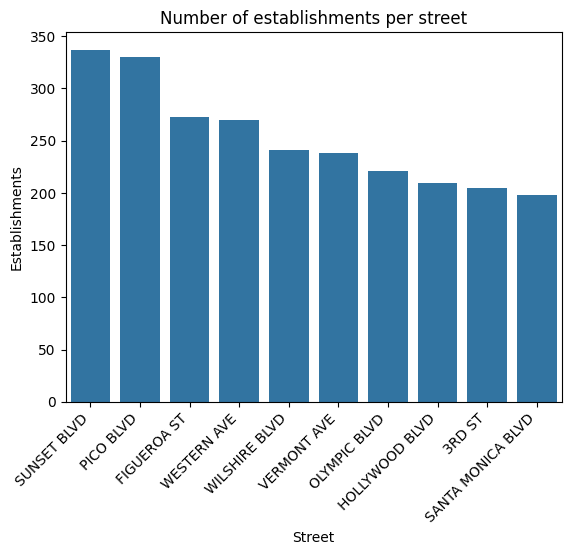

In [21]:

fig = sns.barplot(data=df_st.head(10), x='street', y='rest_num', order = df_st.head(10)['street'])
fig.set_title('Number of establishments per street')
fig.set_ylabel('Establishments')
fig.set_xlabel('Street')
plt.xticks(rotation=45, ha='right')
plt.show()

In [22]:
single_res_street = df_st[df_st['rest_num']==1]['street'].count()
print(single_res_street, 'streets have only 1 establishment')

657 streets have only 1 establishment


In [23]:
df_merged = pd.merge(df_st.head(10), df[['street','number']], how='left', on='street')

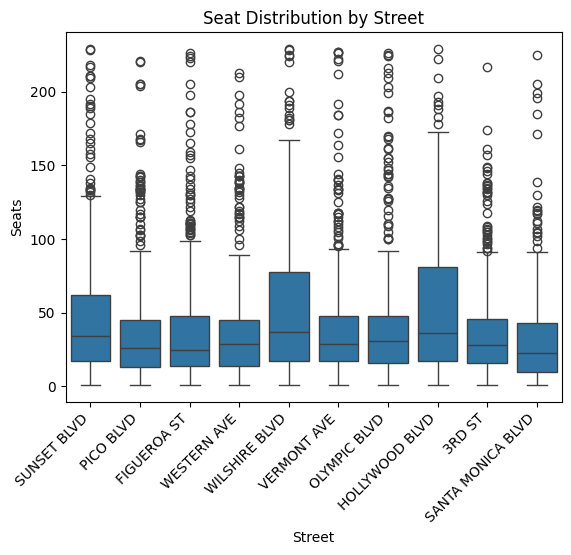

In [24]:
fig = sns.boxplot(data=df_merged, x='street', y='number')
fig.set_title('Seat Distribution by Street')
fig.set_ylabel('Seats')
fig.set_xlabel('Street')
plt.xticks(rotation=45, ha='right')
plt.show()

Looking at the distribution, we see that the streets with the highest number of establishments have an average of 25 seats per establishment. This indicates a large number of small establishments competing with each other.

In [25]:
df_st_type = df.groupby(['object_type','street'], as_index=False, observed=True).agg({'object_name':'count'})
df_st_type_top = df_st_type[df_st_type['street'].isin(df_st['street'].head(10))]

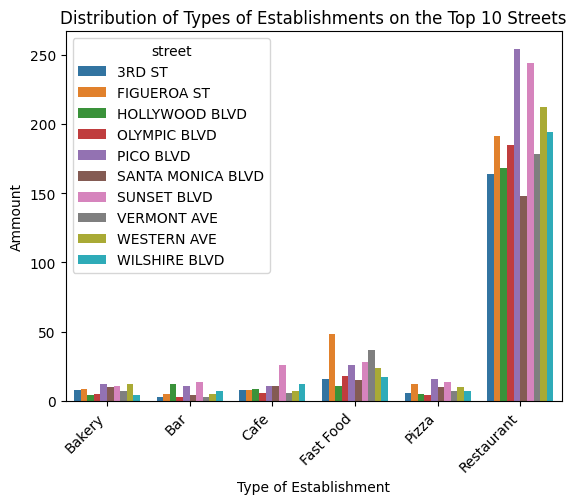

In [26]:
fig = sns.barplot(data=df_st_type_top, x='object_type', y='object_name', hue='street')
fig.set_title('Distribution of Types of Establishments on the Top 10 Streets')
fig.set_ylabel('Ammount')
fig.set_xlabel('Type of Establishment')
plt.xticks(rotation=45, ha='right')
plt.show()

Here we can see that the streets with the highest number of establishments mainly have restaurants.

### Conclusion:

Key recommendations:

* Type:
    - We can proceed with the plan to open a small coffee shop; a fast food restaurant is also an interesting option. Both have similar recommendations in terms of number of seats, less competition (4.5% and 11% of the market, respectively), and opportunities for chain growth.

* Number of seats:
    - In the case of a coffee shop, the average is around 25 seats per establishment, and in the case of a fast food restaurant, 40 seats. 

* Location:
    - The streets with the highest concentration of establishments mainly contain restaurants, with a much smaller number of coffee shops and fast food restaurants. Because of this, I believe it is better to select a location with few establishments, with 657 streets containing only one, to reduce competition and allow the creation of a captive clientele that will keep the establishment operating when the novelty of robots wears off.
    - Another alternative is to choose streets with the highest number of establishments. The high number of competing establishments indicates a heated market that can support another small coffee shop or fast food restaurant. In this case, the focus would be on rapid expansion into a chain.

* Potential for network growth:
    - It is possible to expand the establishment into a network. Both coffee shops and fast food restaurants have a larger market share when we look only at franchised establishments (from 4.5% to 7.2% for coffee shops, and from 11% to 16.5% for fast food restaurants).